# GAN - Generative Adversarial Networks

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "gan"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Fashion MNIST GAN

### 데이터 생성

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### GAN 모델

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

2021-08-06 08:31:50.838844: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 모델을 컴파일

In [4]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

### 모델 훈련

In [5]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [6]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     
        plt.show()                                                    

In [7]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Epoch 1/1


2021-08-06 08:31:51.999828: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


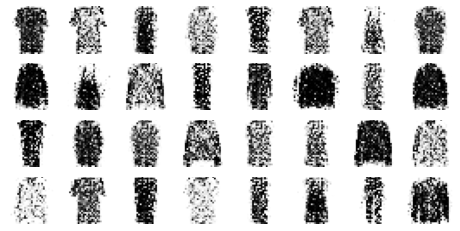

In [8]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

## DCGAN

### 모델 생성

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

### 모델 컴파일

In [10]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

### 크기 변경 과 스케일 조정

In [11]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

### 모델 훈련

In [12]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


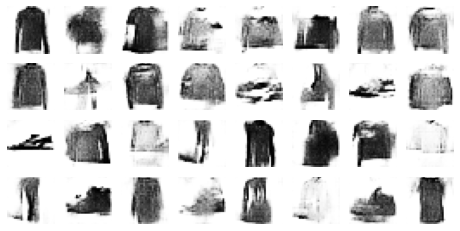

Epoch 2/50


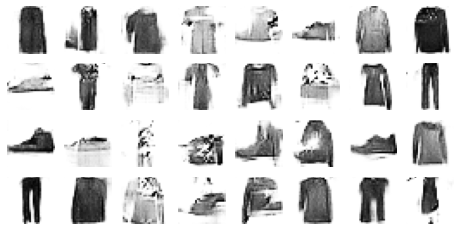

Epoch 3/50


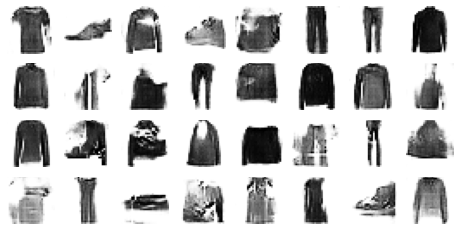

Epoch 4/50


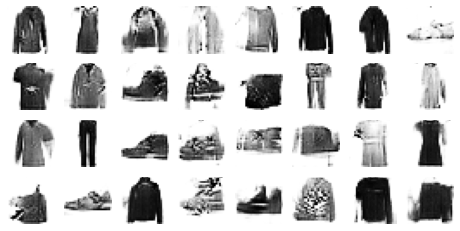

Epoch 5/50


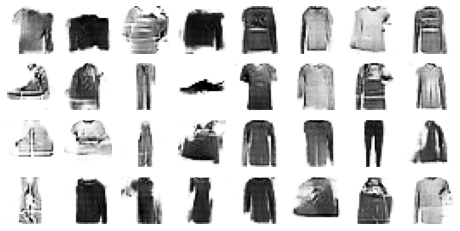

Epoch 6/50


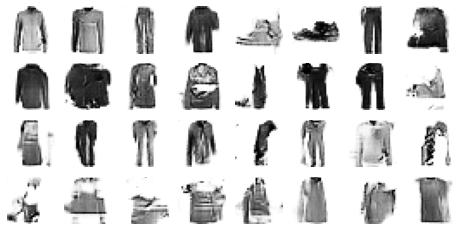

Epoch 7/50


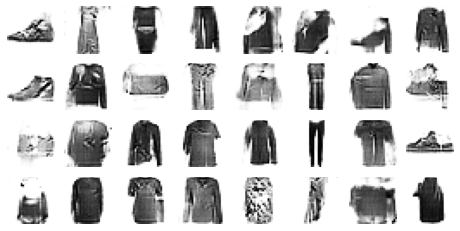

Epoch 8/50


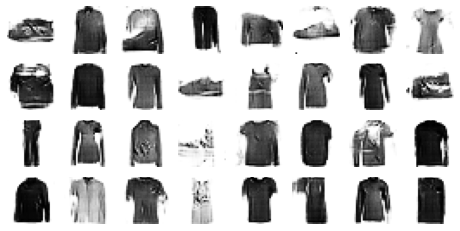

Epoch 9/50


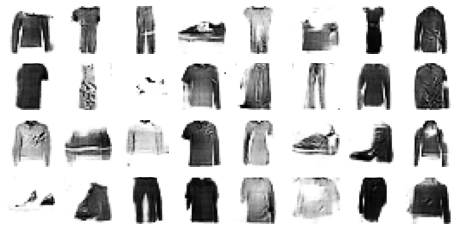

Epoch 10/50


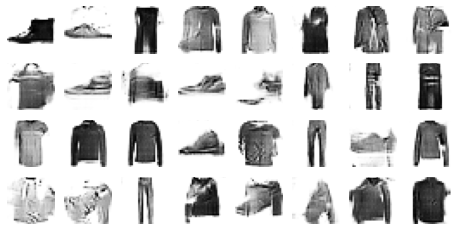

Epoch 11/50


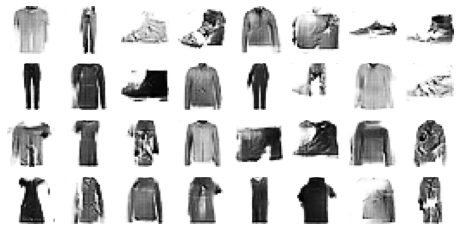

Epoch 12/50


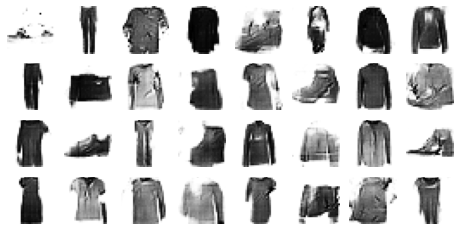

Epoch 13/50


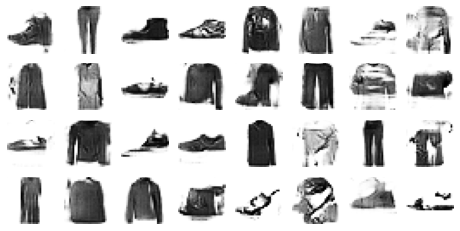

Epoch 14/50


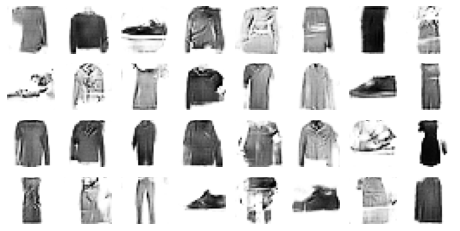

Epoch 15/50


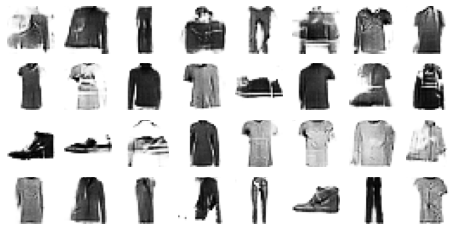

Epoch 16/50


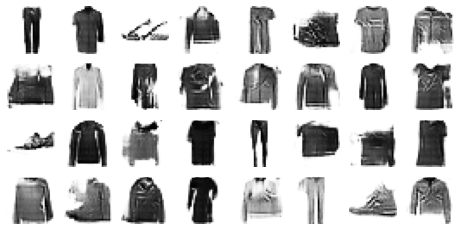

Epoch 17/50


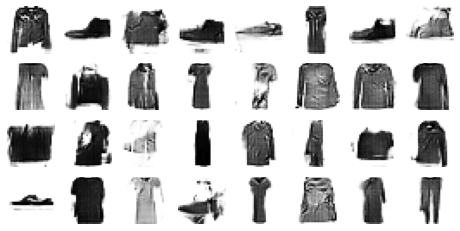

Epoch 18/50


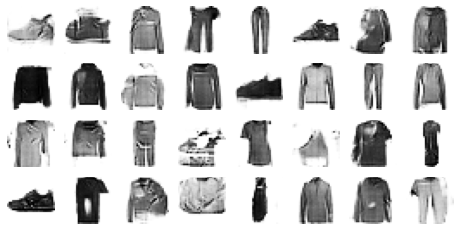

Epoch 19/50


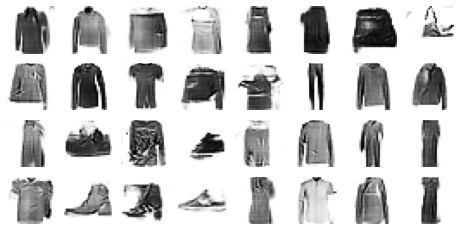

Epoch 20/50


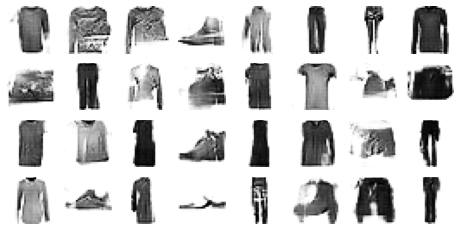

Epoch 21/50


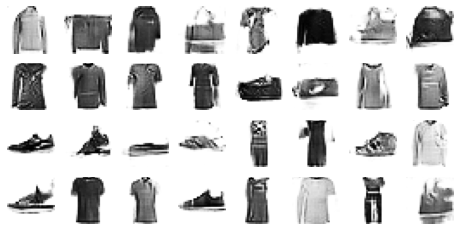

Epoch 22/50


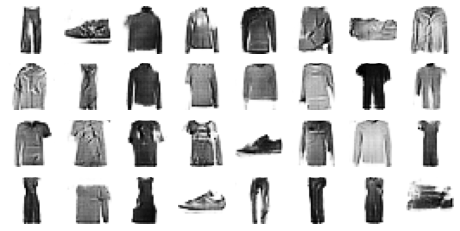

Epoch 23/50


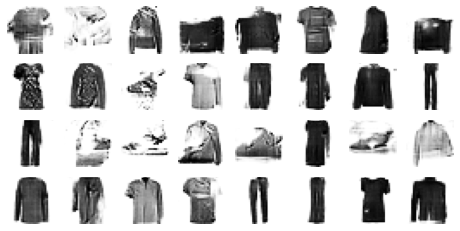

Epoch 24/50


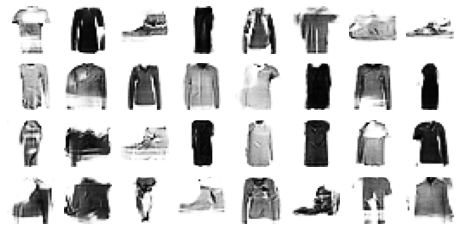

Epoch 25/50


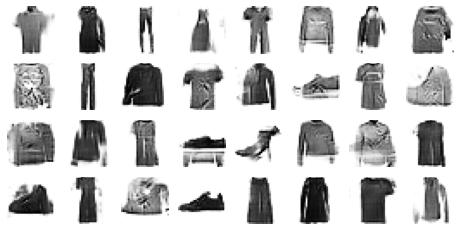

Epoch 26/50


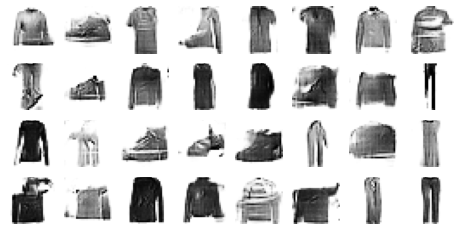

Epoch 27/50


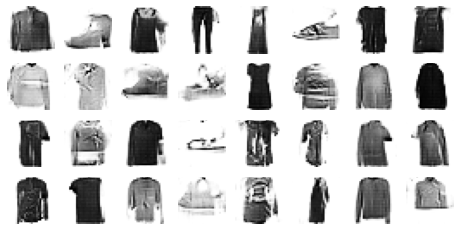

Epoch 28/50


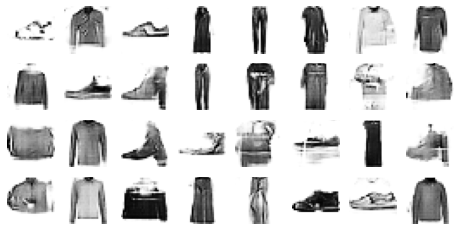

Epoch 29/50


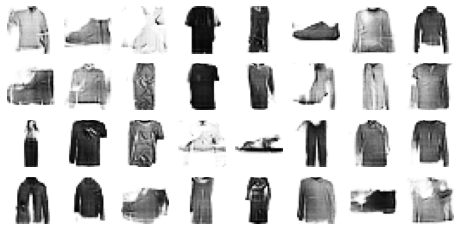

Epoch 30/50


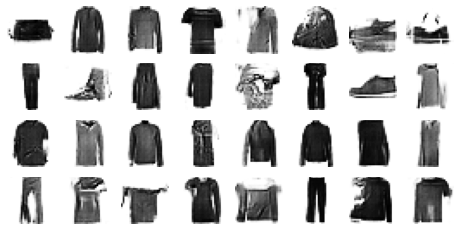

Epoch 31/50


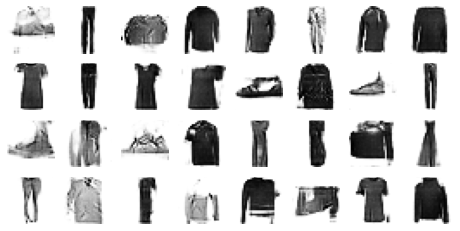

Epoch 32/50


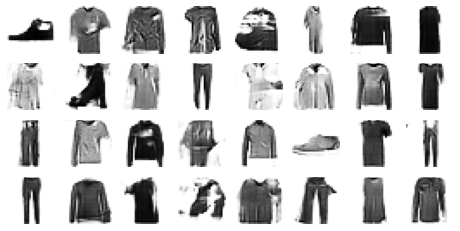

Epoch 33/50


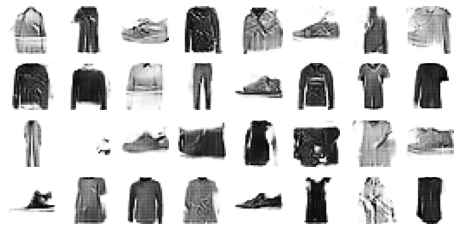

Epoch 34/50


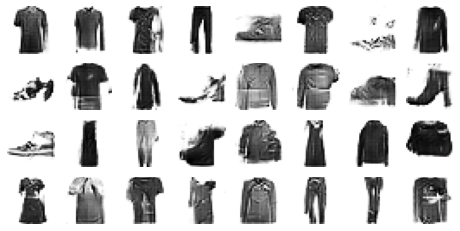

Epoch 35/50


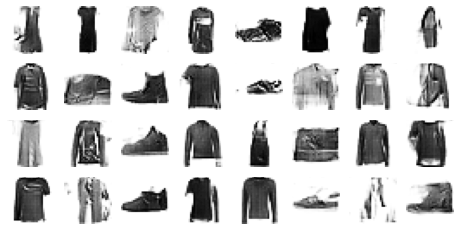

Epoch 36/50


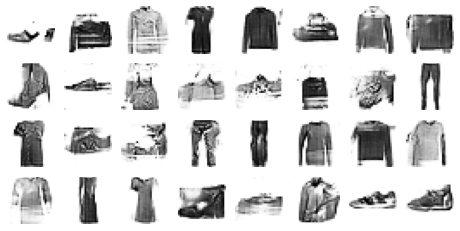

Epoch 37/50


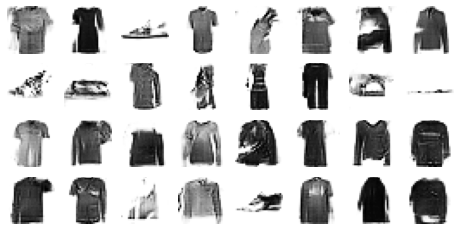

Epoch 38/50


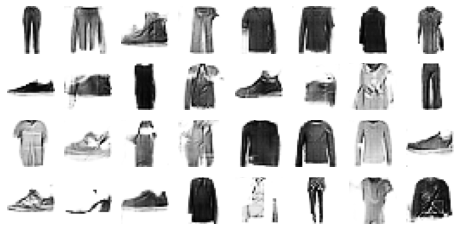

Epoch 39/50


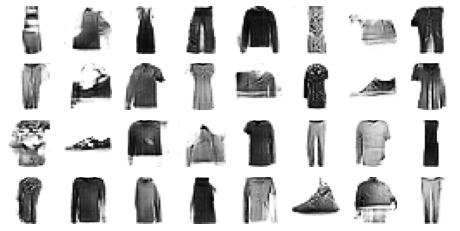

Epoch 40/50


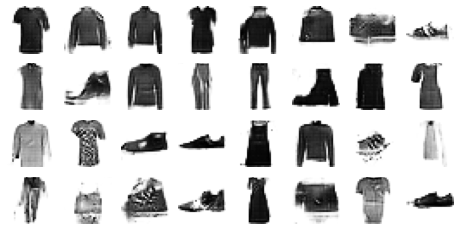

Epoch 41/50


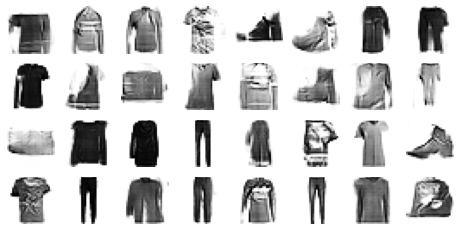

Epoch 42/50


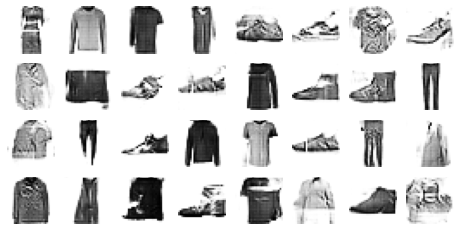

Epoch 43/50


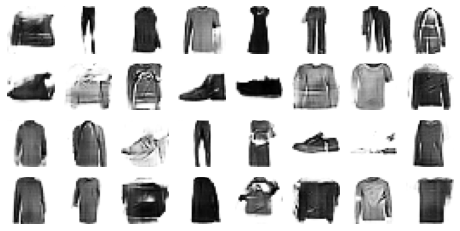

Epoch 44/50


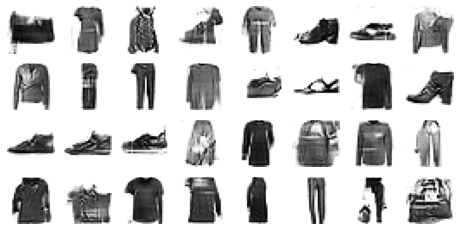

Epoch 45/50


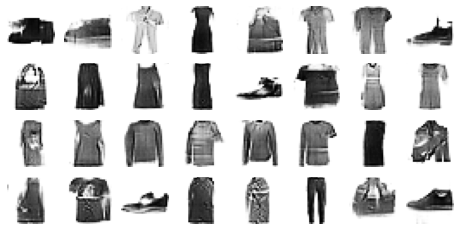

Epoch 46/50


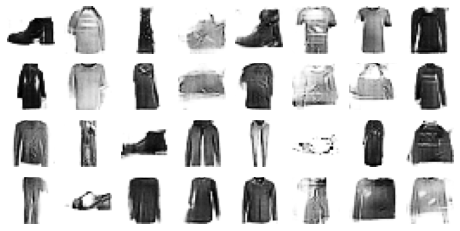

Epoch 47/50


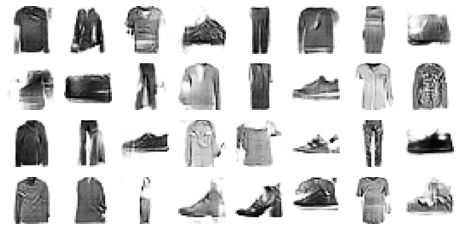

Epoch 48/50


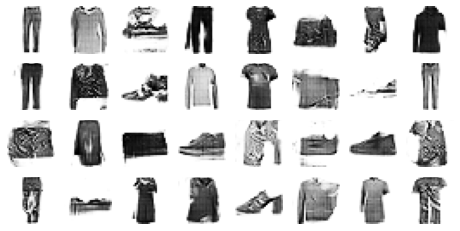

Epoch 49/50


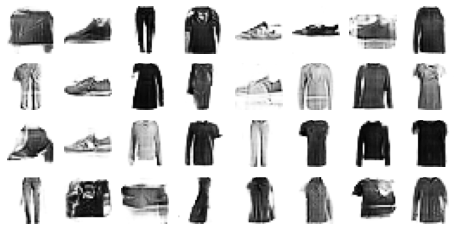

Epoch 50/50


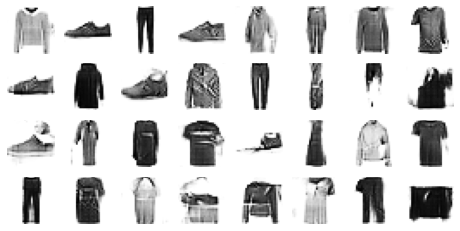

In [13]:
train_gan(gan, dataset, batch_size, codings_size)

Saving figure dcgan_generated_images_plot


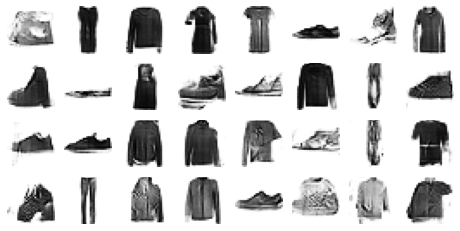

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

In [17]:
import pandas
from pandas import DataFrame
li = pandas.read_html('https://ko.wikipedia.org/wiki/%EC%9D%B8%EA%B5%AC%EC%88%9C_%EB%82%98%EB%9D%BC_%EB%AA%A9%EB%A1%9D')

imsi = DataFrame(li[0])
print(imsi.head())


     0      1             2       3        4
0  1.0     중국  1.411779e+09  2020.0  공식 인구시계
1  2.0     인도  1.379620e+09  2020.0  공식 인구시계
2  3.0     미국  3.329151e+08  2020.0  공식 인구시계
3  4.0  인도네시아  2.763618e+08  2020.0  공식 인구시계
4  5.0   파키스탄  2.251999e+08  2020.0  공식 인구시계


## Style Transfer

### 라이브러리 가져오기

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image

### Contents 이미지

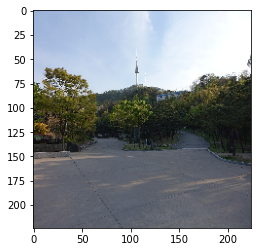

In [2]:
# 남산타워 원경 사진
contents = cv2.imread('./data/contents.jfif')
contents = cv2.resize(contents, (224, 224))
plt.imshow(cv2.cvtColor(contents,cv2.COLOR_BGR2RGB))

### Style 이미지

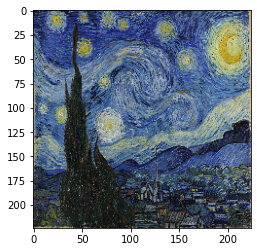

In [3]:
# 고흐 작품
style = cv2.imread('./data/style.jpg')
style = cv2.resize(style, (224, 224))
plt.imshow(cv2.cvtColor(style,cv2.COLOR_BGR2RGB))

### 사전 학습된 모델 가져오기

In [5]:
vgg_model=tf.keras.applications.VGG16(input_shape=(224,224,3),
                                      include_top=False,weights='imagenet')
vgg_model.trainable=False
tf.keras.utils.plot_model(vgg_model,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### 스타일 변환 모델

In [6]:
style_transfer_model=tf.keras.Model(inputs=[vgg_model.input],
                                    outputs=[
                                            vgg_model.get_layer(name='block1_conv2').output,
                                            vgg_model.get_layer(name='block2_conv2').output,
                                            vgg_model.get_layer(name='block3_conv3').output,
                                            vgg_model.get_layer(name='block4_conv3').output
])

style_transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
style_true_b1c1, style_true_b2c2, style_true_b3c3, style_true_b4c3 = \
style_transfer_model.predict(np.reshape(style,(-1,224,224,3)))

style_true_b1c1.shape

2021-08-08 17:27:00.945621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


(1, 224, 224, 64)

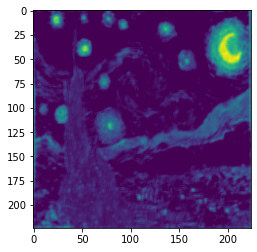

In [8]:
plt.imshow(style_true_b1c1[0][:,:,60])

In [9]:
contents_true_b1c1, contents_true_b2c2, contents_true_b3c3, contents_true_b4c3 = \
style_transfer_model.predict(np.reshape(contents,(-1,224,224,3)))

contents_true_b3c3.shape

(1, 56, 56, 256)

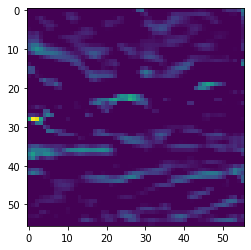

In [10]:
plt.imshow(contents_true_b3c3[0][:,:,250])

In [11]:
def gram_matrix(x):
    reshape_x=tf.transpose(x,[2,1,0])
    s = tf.shape(reshape_x)
    reshape_x=tf.reshape(reshape_x,(s[0],s[1]*s[2]))
    reshape_x_t=tf.transpose(reshape_x)
    dot=tf.matmul(reshape_x,reshape_x_t)
    dot=tf.cast(dot,dtype='float32')
    dot=dot/tf.cast(tf.shape(reshape_x)[0], tf.float32)/tf.cast(tf.shape(reshape_x)[1], tf.float32)
    return dot

gram_matrix(contents_true_b3c3[0])

<tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[671.0898    , 300.31064   ,  29.798231  , ...,  79.880554  ,
         32.29057   ,  33.506172  ],
       [300.31064   , 677.1567    ,  38.14758   , ...,  76.13144   ,
         61.756313  ,  23.604467  ],
       [ 29.798231  ,  38.14758   ,  61.723618  , ...,  18.556238  ,
          0.72043437,   0.76895136],
       ...,
       [ 79.880554  ,  76.13144   ,  18.556238  , ..., 184.68987   ,
         18.2624    ,   1.3970356 ],
       [ 32.29057   ,  61.756313  ,   0.72043437, ...,  18.2624    ,
         94.53125   ,   5.902391  ],
       [ 33.506172  ,  23.604467  ,   0.76895136, ...,   1.3970356 ,
          5.902391  ,  25.22562   ]], dtype=float32)>

In [12]:
# 스타일 변환을 적용할 남산타워 이미지 
input_image = cv2.imread('./data/contents.jfif')
input_image = cv2.resize(input_image, (224, 224))


1
s_loss tf.Tensor(1016712.3, shape=(), dtype=float32)
c_loss_3 tf.Tensor(0.0, shape=(), dtype=float32)

2
s_loss tf.Tensor(424104.94, shape=(), dtype=float32)
c_loss_3 tf.Tensor(73172.9, shape=(), dtype=float32)

3
s_loss tf.Tensor(298517.66, shape=(), dtype=float32)
c_loss_3 tf.Tensor(141593.75, shape=(), dtype=float32)

4
s_loss tf.Tensor(292573.75, shape=(), dtype=float32)
c_loss_3 tf.Tensor(107683.195, shape=(), dtype=float32)

5
s_loss tf.Tensor(220795.92, shape=(), dtype=float32)
c_loss_3 tf.Tensor(154728.11, shape=(), dtype=float32)

6
s_loss tf.Tensor(233429.5, shape=(), dtype=float32)
c_loss_3 tf.Tensor(120586.164, shape=(), dtype=float32)

7
s_loss tf.Tensor(191056.52, shape=(), dtype=float32)
c_loss_3 tf.Tensor(169417.53, shape=(), dtype=float32)

8
s_loss tf.Tensor(200230.0, shape=(), dtype=float32)
c_loss_3 tf.Tensor(126497.04, shape=(), dtype=float32)

9
s_loss tf.Tensor(148290.69, shape=(), dtype=float32)
c_loss_3 tf.Tensor(162468.98, shape=(), dtype=float32)

10
s_los

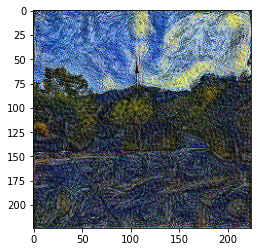

In [13]:
img_avi=np.zeros((224,224,3))
opt=tf.keras.optimizers.Adam(10.0)

fcc=cv2.VideoWriter_fourcc(*'DIVX')
out=cv2.VideoWriter('style_transfer.avi',fcc,10.0,(224,224))

for epoch in range(200):
    input_image=tf.reshape(input_image,(-1,224,224,3))
    input_image=tf.cast(input_image,dtype='float32')
    input_image = tf.Variable(input_image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        
        b1c1,b2c2,b3c3,b4c3=style_transfer_model(input_image)
        
        s_loss_1=tf.stop_gradient(gram_matrix(style_true_b1c1[0]))-gram_matrix(b1c1[0])
        s_loss_1=tf.reduce_mean(tf.square(s_loss_1))
        s_loss_2=tf.stop_gradient(gram_matrix(style_true_b2c2[0]))-gram_matrix(b2c2[0])
        s_loss_2=tf.reduce_mean(s_loss_2*s_loss_2)
        s_loss_3=tf.stop_gradient(gram_matrix(style_true_b3c3[0]))-gram_matrix(b3c3[0])
        s_loss_3=tf.reduce_mean(s_loss_3*s_loss_3)
        s_loss_4=tf.stop_gradient(gram_matrix(style_true_b4c3[0]))-gram_matrix(b4c3[0])
        s_loss_4=tf.reduce_mean(s_loss_4*s_loss_4)
              
        c_loss_1=contents_true_b1c1-b1c1
        c_loss_1=tf.reduce_mean(tf.square(c_loss_1))
        c_loss_2=contents_true_b2c2-b2c2
        c_loss_2=tf.reduce_mean(tf.square(c_loss_2))
        c_loss_3=contents_true_b3c3-b3c3
        c_loss_3=tf.reduce_mean(tf.square(c_loss_3))
        c_loss_4=contents_true_b4c3-b4c3
        c_loss_4=tf.reduce_mean(tf.square(c_loss_4))

        s_loss=(s_loss_1+s_loss_2+s_loss_3+s_loss_4)
        c_loss=(c_loss_1+c_loss_2+c_loss_3+c_loss_4)/4.
        loss=s_loss*10.0+c_loss_3
    grad=tape.gradient(loss,input_image)
    opt.apply_gradients([(grad,input_image)])
    input_image=tf.cast(input_image,dtype=tf.int32)
    input_image=tf.clip_by_value(input_image,0,255)
    img_avi=input_image.numpy()[0]
    if((epoch+0)%10==0):
        cv2.imwrite('{}.jpg'.format(epoch), img_avi)
    out.write(np.uint8(img_avi))
    print()
    print(epoch+1)
    print('s_loss',s_loss)
    print('c_loss_3',c_loss_3)
plt.imshow(input_image[0][:,:,::-1])
out.release()
cv2.destroyAllWindows()